# Wake behind a cylinder at Re=100

Jared Callaham (2020)

The incompressible flow past a circular cylinder at moderate Reynolds number can be described by the two-dimensional Navier-Stokes equations:
$$ \mathbf{u}_t + (\mathbf{u} \cdot \nabla )\mathbf{u} = -\nabla p + \frac{1}{\mathrm{Re}} \nabla^2 \mathbf{u} $$
The wake is characterized by a von Karman vortex street.  Simple scaling arguments suggest that the wake should be approximately inviscid, while the region close to the cylinder is viscous with a relatively weak unsteady component.
In this notebook we will focus on dominant balance of the streamwise component $u$, although the same analysis could be easily applied to the cross-stream component or vorticity equation.

__NOTE:__ A dependency for this case is `neksuite` to load the file.  This should be saved separately as a .mat file..

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint, permutation
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy.interpolate import griddata

import sys
sys.path.append('/Users/jcallaham/Dropbox/Documents/python/pymech/src/')
import neksuite as nek

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
%config InlineBackend.figure_format = 'retina'

from matplotlib.colors import ListedColormap
# Colormap for segmentation

import seaborn as sns
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

Re = 100 # Reynolds number of the flow

### Useful functions for interpolating spectral element domain

In [2]:
# Define interpolation function (mainly for plotting)
def interp(field, method='nearest', mask=None):
    """
    field - 1D array of cell values
    mask - if exists, should be an ngrid-dim logical that will be set to zero
    """
    global Cx, Cy, X, Y, nx, ny
    ngrid = len(X.flatten())
    grid_field = np.squeeze( np.reshape( griddata((Cx, Cy), field, (X, Y), method=method), (ngrid, 1)) )
    if mask is not None:
        grid_field[np.logical_not(mask.flatten('F'))] = 0
    return np.reshape( grid_field, [ny, nx], order='F' )

### Load Nek5000 data

Gradients are computed internally in the Nek5000 solver and saved to the "f" files

In [3]:
flow_path = '.data/cyl/'

# Load mass matrix
dOmega = np.loadtxt(flow_path+'mass_matrix.dat')  # IS THIS USED FOR ANYTHING??

# Load files... note that the extra terms got saved at the zero time step (velocity did not)
t_idx = 1
dt = 0.06

filename = lambda t_idx: 'cyl0.f{0:05d}'.format(t_idx)

# Read mesh from first time step
field = nek.readnek(flow_path+filename(1))
nel = len(field.elem) # Number of spectral elements
nGLL = 7 # Order of the spectral mesh
n = nel*nGLL**2

Cx = np.array([field.elem[i].pos[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
Cy = np.array([field.elem[i].pos[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

# Read velocity, vorticity, and mesh
field = nek.readnek(flow_path+filename(t_idx))

u = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
v = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
vort = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

# Read forward time step for acceleration term
field = nek.readnek(flow_path+filename(t_idx+1))

u_next = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
v_next = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
vort_next = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

# Finite-difference time derivative
ut = (u_next-u)/dt
vt = (v_next-v)/dt
vort_t = (vort_next-vort)/dt

# Gradient terms
field = nek.readnek(flow_path+'du_'+filename(t_idx))
ux = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
uy = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

field = nek.readnek(flow_path+'dv_'+filename(t_idx))
vx = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
vy = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

# Laplacian terms
field = nek.readnek(flow_path+'lap'+filename(t_idx))
lapu = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
lapv = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

# Pressure gradients
field = nek.readnek(flow_path+'dp_'+filename(t_idx))
px = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
py = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

# Vorticity terms (remember Laplacian is stored in the temperature field)
field = nek.readnek(flow_path+'vrt'+filename(t_idx))
vort_x = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
vort_y = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
vort_lap = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

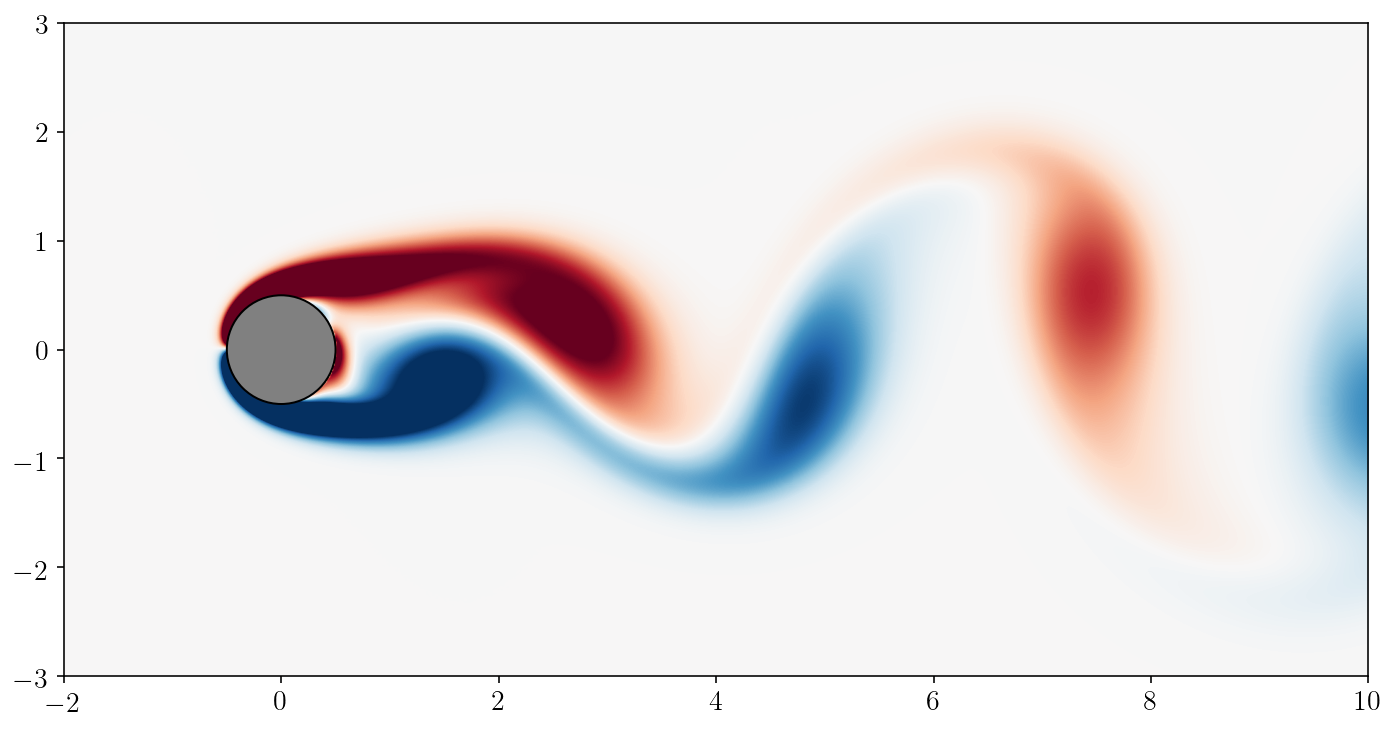

In [4]:
# Plot vorticity on a restricted domain

def cyl_plot(x, y, field, vmin=-2, vmax=2):
    """Plot cylinder field with masked circle"""
    plt.imshow(field, cmap='RdBu', vmin=vmin, vmax=vmax, origin='lower',
               extent=[min(x), max(x), min(y), max(y)], interpolation='gaussian')
    cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
    plt.gcf().gca().add_artist(cyl)

nx = 800
ny = 400
x = np.linspace(-2, 10, nx)
y = np.linspace(-3, 3, ny)
Y, X, = np.meshgrid(y, x)
mask = ((X.T**2 + Y.T**2) > 0.25 )  # Boundary of cylinder


vort_grid = interp(vort, method='cubic', mask=mask)
plt.figure(figsize=(12, 6))
cyl_plot(x, y, vort_grid)

plt.show()

# 1. Equation space representation

The streamwise equation is
$$ u_t + (\mathbf{u} \cdot \nabla) u = -p_x + \frac{1}{\mathrm{Re}} \nabla^2 u $$
Note that the advection terms and viscosity could be split into two separate terms.  Here we will combine them for ease of visualization and interpretation.  The full equation space is then four-dimensional, with terms corresponding to the unsteadiness, advection, pressure gradient, and viscosity.

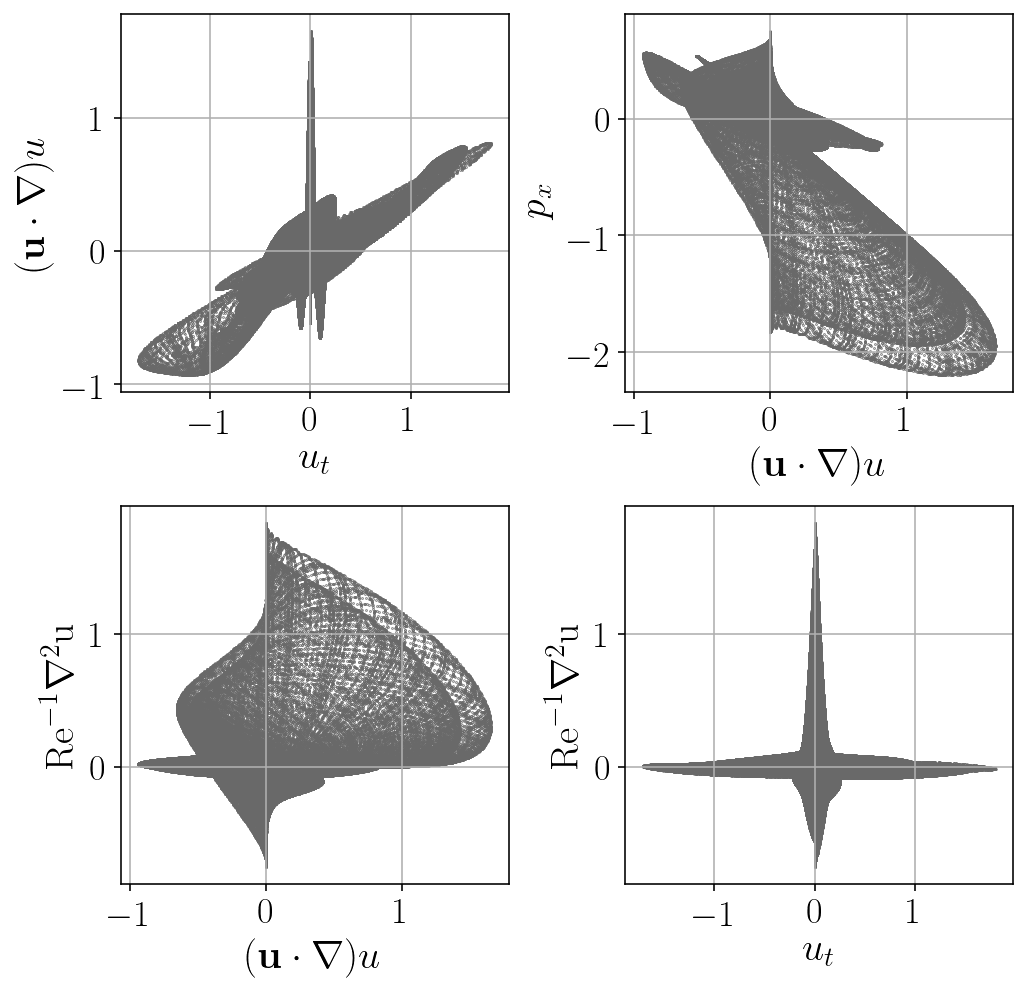

In [5]:
# Form matrix of the equation space terms.
features = np.vstack([ut, u*ux+v*uy, px, -lapu/Re]).T

labels = [r'$u_t$', r'$(\mathbf{u} \cdot \nabla) u$', r'$p_x$', r'$\rm{Re}^{-1} \nabla^2 u$']

# 2D views of equation space
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.scatter(features[:, 0], features[:,1], .1, 'dimgrey')
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[1], fontsize=20)
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[:, 1], features[:,2], .1, 'dimgrey')
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[2], fontsize=20)
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(223)
plt.scatter(features[:, 1], features[:,3], .1, 'dimgrey')
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(224)
plt.scatter(features[:, 0], features[:,3], .1, 'dimgrey')
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Visualizing the equation space helps build some intuition.  As expected, it appears that there is one region where the time derivative is small and one where viscosity is small.

# 2. Gaussian mixture model

To make this more concrete, we train a Gaussian mixture model which separates the points into clusters with different means and covariance matrices. 

In [6]:
# Fit Gaussian mixture model
nc = 6  # Number of clusters
#seed = np.random.randint(2**32)
#print(seed)
seed = 3847210123  # Standard seed for debugging/plotting
model = GaussianMixture(n_components=nc, random_state=seed)

model.fit(features)

# "Predict" the clusters based on the trained model
cluster_idx = model.predict(features)

One way to interpret the GMM is by looking directly at the covariance matrices.  The sparsity pattern gives an indication of which terms are inactive in each cluster.  Note that some of the clusters seem to be redundant for describing dominant balance, for instance clusters 2 and 5, or clusters 3 and 6.

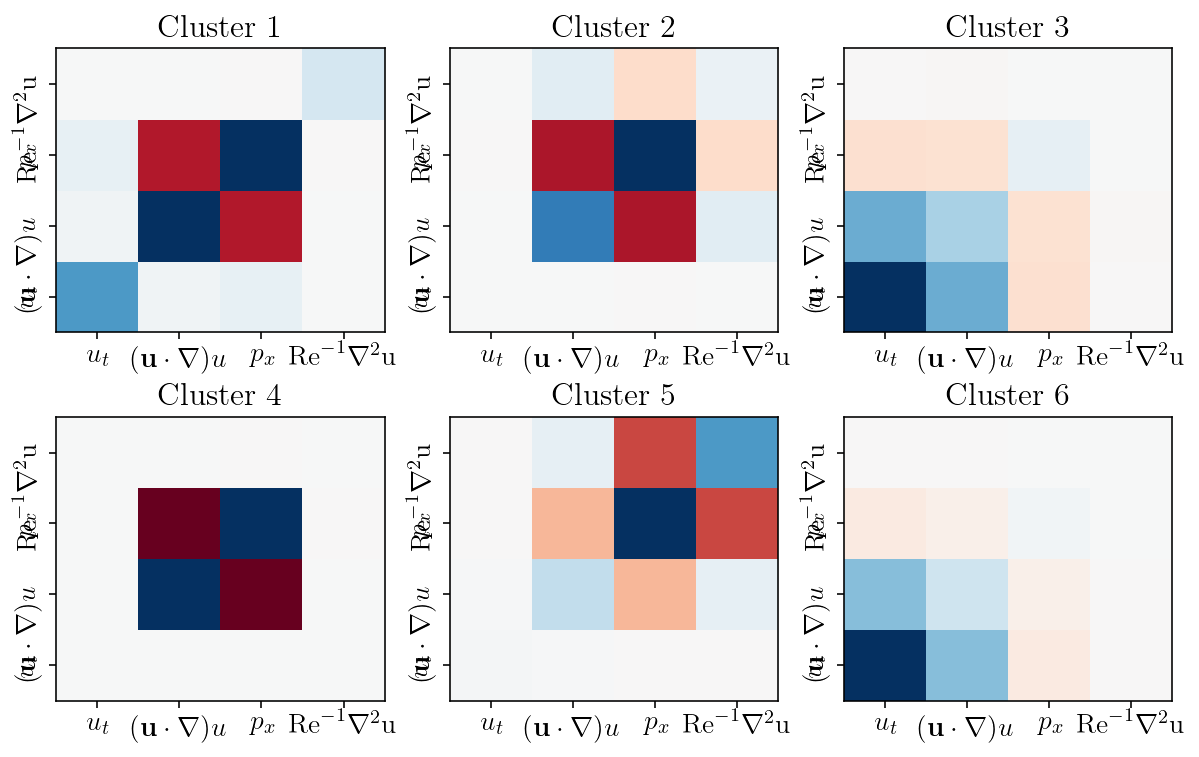

In [7]:
# Plot covariance matrices
nfeatures = features.shape[1]
plt.figure(figsize=(10, 6))
for i in range(nc):
    plt.subplot(2, 3, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+.5))
    plt.gca().set_xticklabels(labels, fontsize=14)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+.5))
    plt.gca().set_yticklabels(labels, fontsize=14, rotation='vertical')
    plt.gca().set_title('Cluster {0}'.format(i+1), fontsize=16)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
plt.show()

We can also visualize the equation space again, this time coloring by the GMM components.

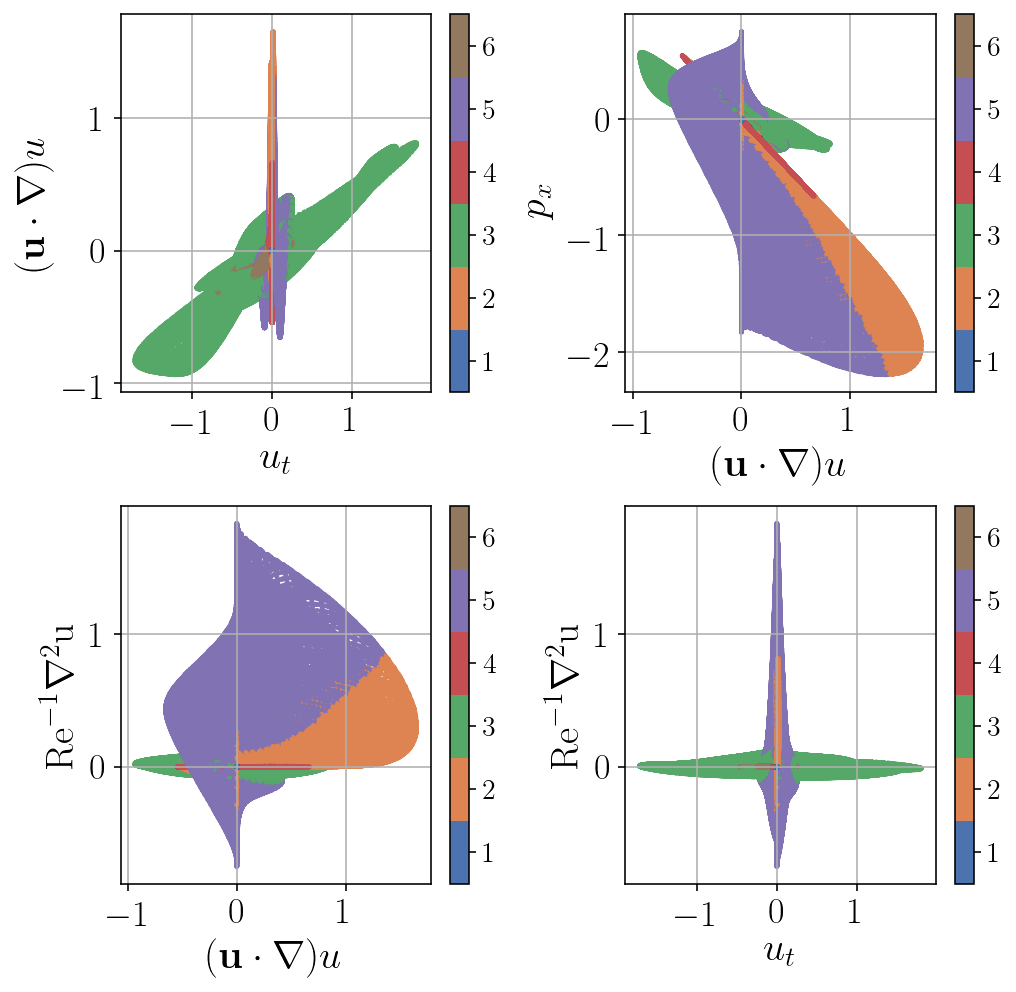

In [8]:
markersize = 2
fontsize = 20
# 2D views of feature space

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.scatter(features[:, 0], features[:,1], markersize, cluster_idx+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[1], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[:, 1], features[:,2], markersize, cluster_idx+1, cmap=cm)
plt.xlabel(labels[1], fontsize=fontsize)
plt.ylabel(labels[2], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(223)
plt.scatter(features[:, 1], features[:,3], markersize, cluster_idx+1, cmap=cm)
plt.xlabel(labels[1], fontsize=fontsize)
plt.ylabel(labels[3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(224)
plt.scatter(features[:, 0], features[:,3], markersize, cluster_idx+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Finally, we can plot the whole flow field, coloring according to GMM component.

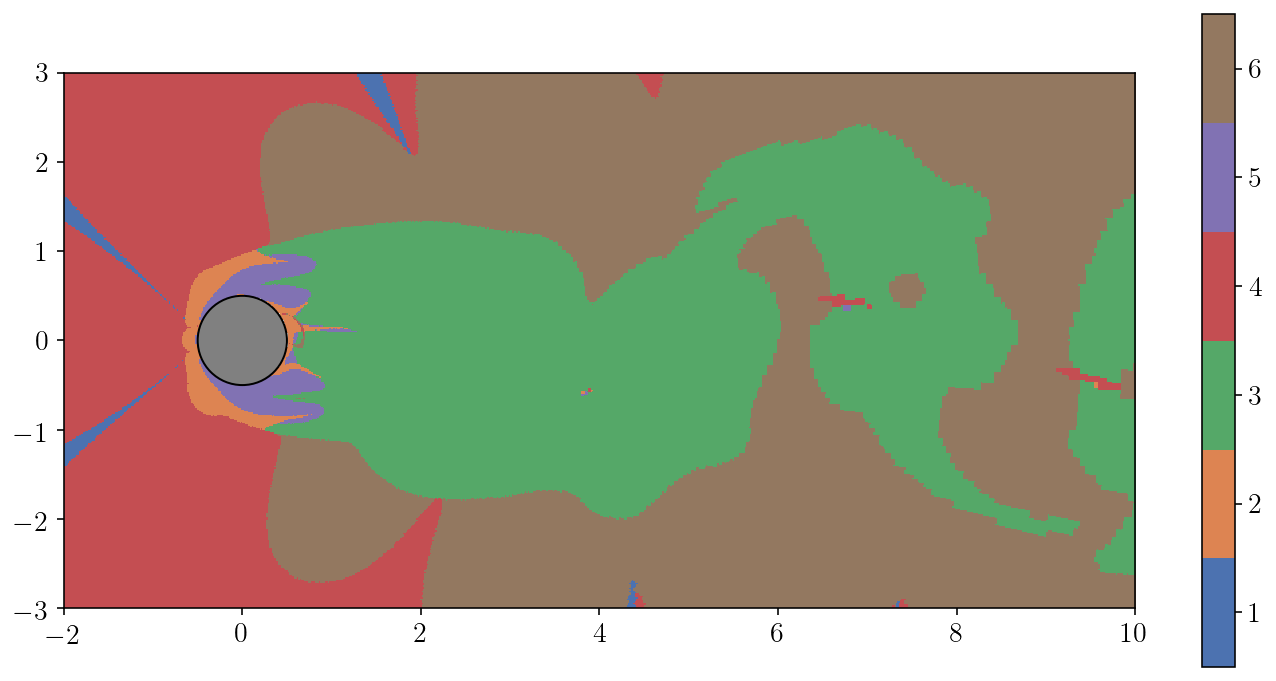

In [9]:
# Interpolate onto uniform grid
clustermap = interp(cluster_idx+1, method='nearest', mask=mask)  # Finite volume features

plt.figure(figsize=(12, 6))
plt.imshow(clustermap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
           extent=[min(x), max(x), min(y), max(y)])
cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
plt.gcf().gca().add_artist(cyl)

plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.show()

# 3. Sparse principal components analysis

To handle the redundancy in clusters and automatically identify the sparsity pattern in each cluster, we apply sparse principal components analysis to the set of points in each GMM cluster.  The leading principal component gives the direction of maximum variance; nonzero components in the sparse approximation correspond to active terms in that cluster.

First, we must choose a regularization value.  We do this with a simple criteria - the norm of discarded terms in the cluster region.

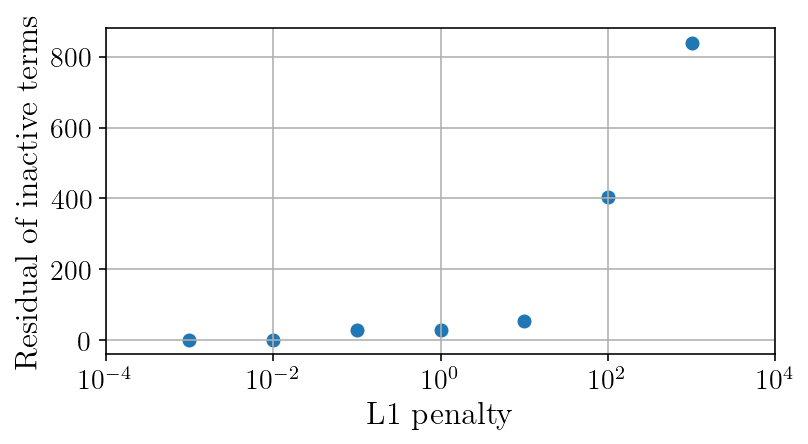

In [17]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1e3]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]  
        spca = SparsePCA(n_components=1, alpha=alphas[k], normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel('L1 penalty', fontsize=16)
plt.ylabel('Residual of inactive terms', fontsize=16)
plt.gca().set_xscale('log')
plt.xlim([1e-4, 1e4])
plt.grid()
plt.show()

We'll choose the greatest regularization before the residual starts to grow dramatically: $\alpha=10$.  Then we re-run the SPCA with the chosen value and keep track of the nonzero variance directions in each cluster

In [11]:
# Sparse PCA to identify directions of nonzero variance
term_labels = ['Acceleration', 'Advection', 'Pressure', 'Viscous']

alpha_opt = 10

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i+1))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([term_labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

GMM Cluster 1:
None
GMM Cluster 2:
['Advection', 'Pressure', 'Viscous']
GMM Cluster 3:
['Acceleration', 'Advection', 'Pressure']
GMM Cluster 4:
['Advection', 'Pressure']
GMM Cluster 5:
['Advection', 'Pressure', 'Viscous']
GMM Cluster 6:
['Acceleration', 'Advection']


# 4. Final dominant balance models

As anticipated, there are some redundant clusters.  We can easily look for unique sparsity patterns and figure out which GMM clusters are associated with each sparsity pattern (and therefore dominant balance physics)

SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['Advection', 'Pressure']
SPCA Cluster 2:
['Advection', 'Pressure', 'Viscous']
SPCA Cluster 3:
['Acceleration', 'Advection']
SPCA Cluster 4:
['Acceleration', 'Advection', 'Pressure']


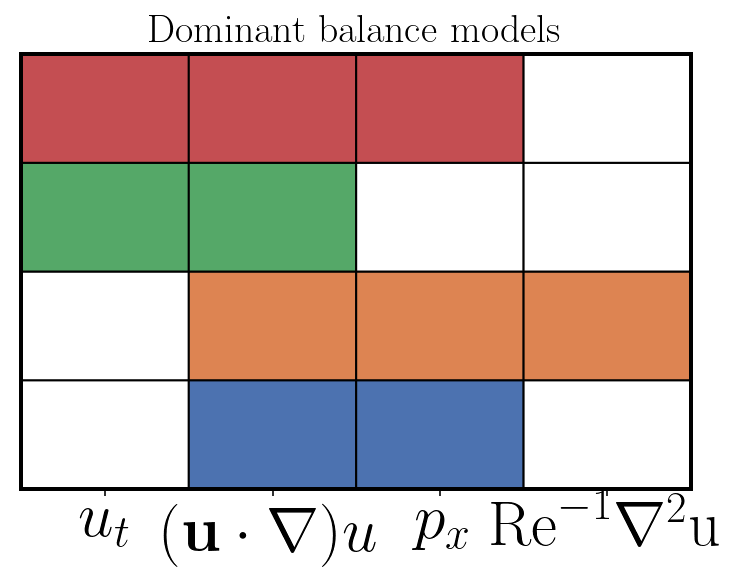

In [12]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([term_labels[k] for k in active_terms])
    else: print('No dynamics')

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = interp(balance_idx, method='nearest', mask=mask)

# Plot a grid for active terms in each model
gridmap = balance_models.copy()
gridmap = (gridmap.T*np.arange(nmodels)).T  # Scale map so that active terms can be color-coded

plt.figure(figsize=(6, 4))
plt.pcolor(gridmap[1:, :], vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=32)
plt.gca().set_yticks([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
    
plt.title('Dominant balance models')
plt.show()

As anticipated, we find inviscid regions (red and green), and approximately steady regions (orange and blue), with slightly different balances. In particular, the orange model is what the scaling analysis predicts for the near-cylinder region, while the other three are consistent with the wake.

We can confirm this by visualizing the final local dominant balance model across the field:

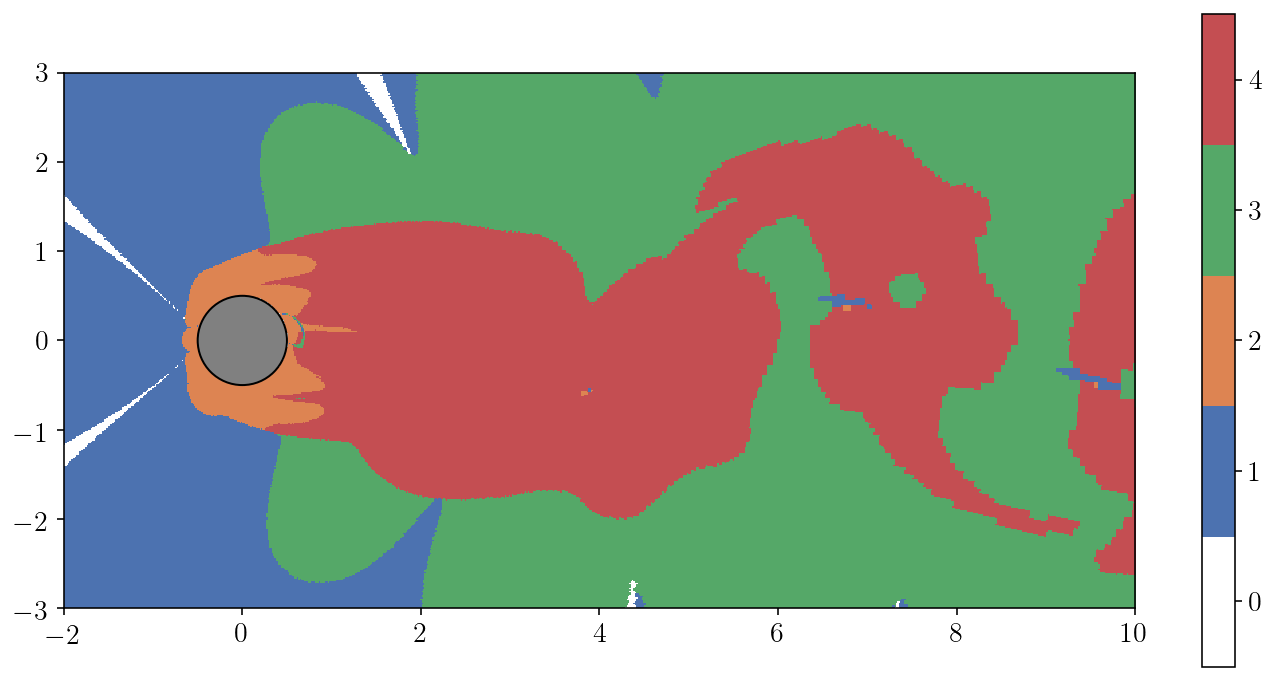

In [13]:
plt.figure(figsize=(12, 6))
plt.imshow(balancemap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
           extent=[min(x), max(x), min(y), max(y)])
cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
plt.gcf().gca().add_artist(cyl)

plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.show()

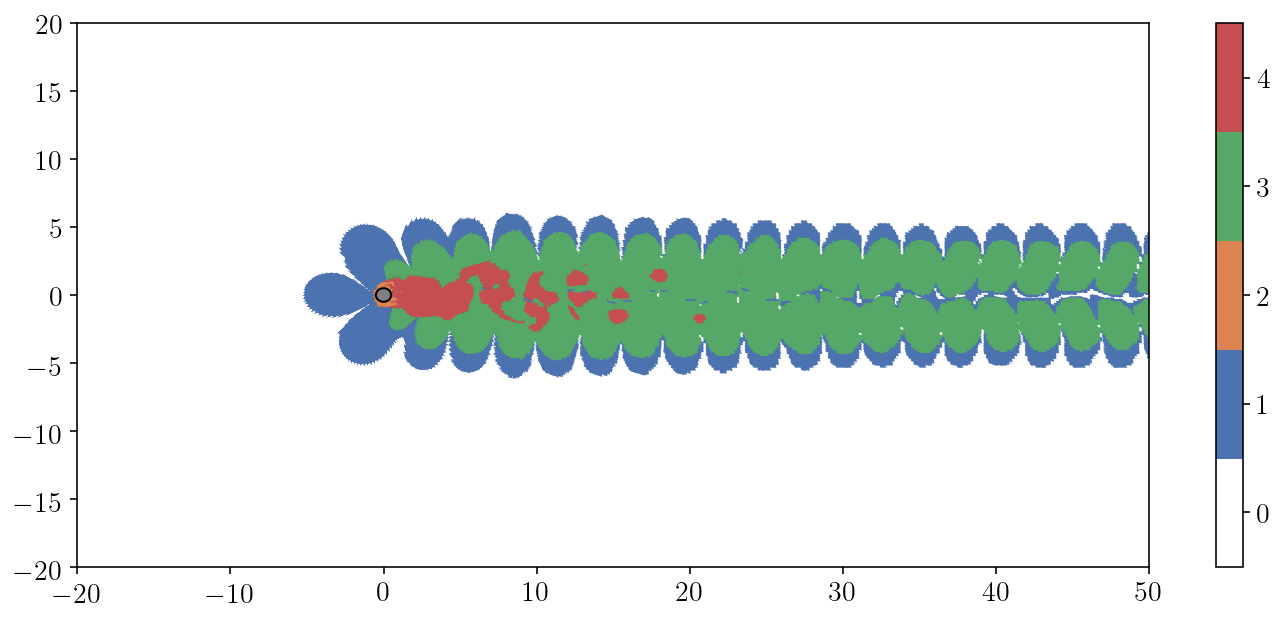

In [14]:
# Zoom out to entire domain

# Scatter plot for finite volume elements

plt.figure(figsize=(12, 5))
plt.scatter(Cx, Cy, s=1, c=balance_idx, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, )
plt.xlim([-20, 50])
plt.ylim([-20, 20])
cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.gcf().gca().add_artist(cyl)
#plt.gca().set_facecolor('gray')
plt.show()

Finally, back in equation space:

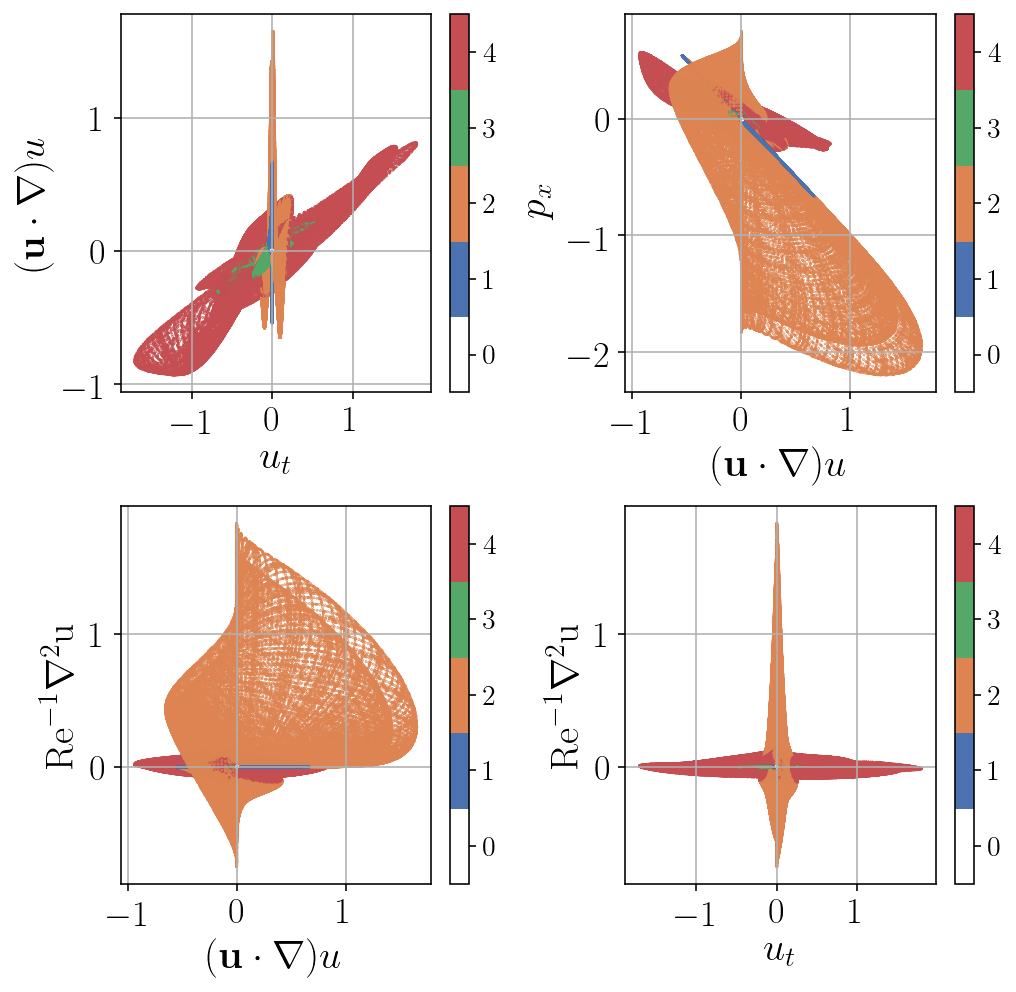

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.scatter(features[:, 0], features[:,1], .1, balance_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[1], fontsize=20)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[:, 1], features[:,2], .1, balance_idx, cmap=cm)
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[2], fontsize=20)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(223)
plt.scatter(features[:, 1], features[:,3], .1, balance_idx, cmap=cm)
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(224)
plt.scatter(features[:, 0], features[:,3], .1, balance_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

# Classification uncertainty

Since the GMM is a probabilistic model, it comes with a natural notion of uncertainty.  We can easily propagate this through the SPCA reduction by summing the uncertainty associated with all models that *don't* ultimately reduce to the same balance relation.  This gives the probability of misclassification.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


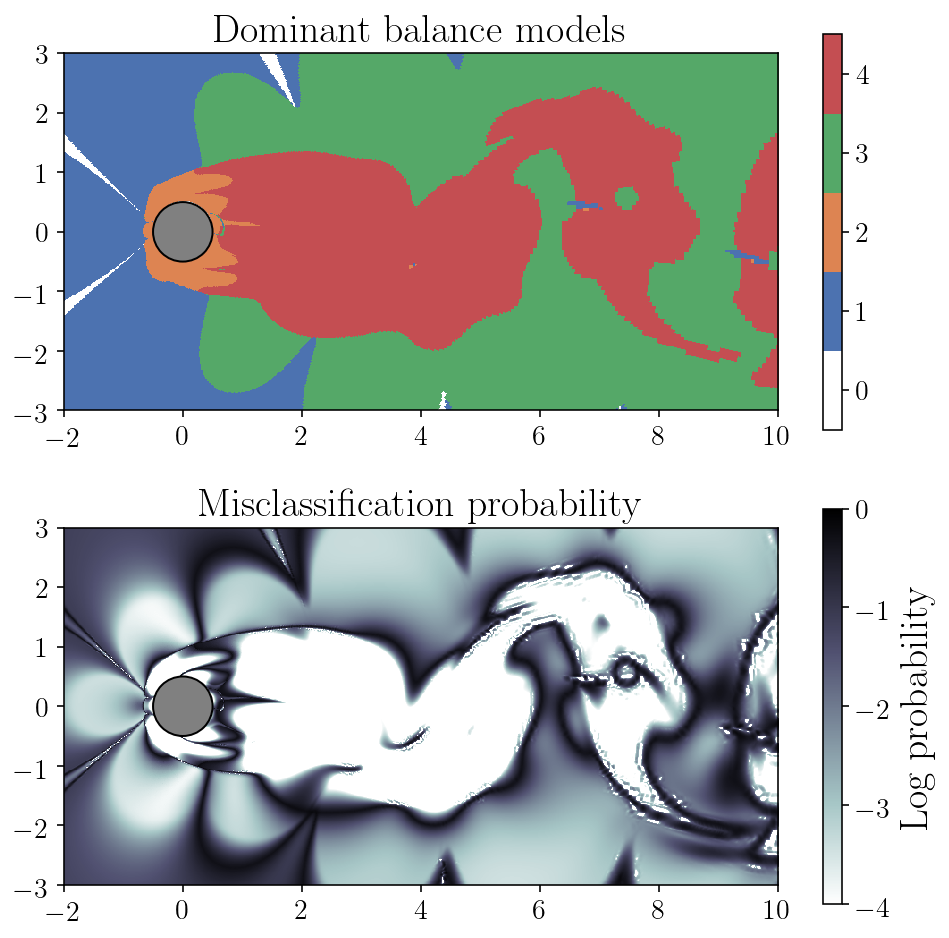

In [16]:
# Predict features again, with probability
cluster_prob = model.predict_proba(features)

# Probability of being in balance model i is the sum of constituent Gaussian mixtures
model_prob = np.zeros((features.shape[0], nmodels))
for i in range(nmodels):
    model_prob[:, i] = np.sum(cluster_prob[:, np.nonzero(model_index==i)[0]], axis=1 )

# Probability of misclassification is the inverse
err_prob = np.zeros((features.shape[0]))
for i in range(features.shape[0]):
    err_prob[i] = 1-model_prob[i, balance_idx[i]]

probmap = interp(err_prob, method='cubic', mask=mask)
    
plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.imshow(balancemap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
           extent=[min(x), max(x), min(y), max(y)])
cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
plt.gcf().gca().add_artist(cyl)
plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.title('Dominant balance models')

plt.subplot(212)
plt.imshow(np.log10(probmap), cmap='bone_r', vmin=-4, vmax=0, origin='lower',
           extent=[min(x), max(x), min(y), max(y)])
cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
plt.gcf().gca().add_artist(cyl)
plt.title('Misclassification probability')
cbar = plt.colorbar()
cbar.set_label('Log probability') 
    
plt.show()
